<a href="https://colab.research.google.com/github/lmarinmu/AlgorithmsUN2024II/blob/main/LABATQ/LMARINMU_LAB_ATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [40]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-sw8x_752
  Resolved https://github.com/quantiacs/toolbox.git to commit 568159460bcffea00317cd4a8ef57ad1b0eb4141
  Preparing metadata (setup.py) ... done


In [41]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0   8582      0 --:--:-- --:--:-- --:--:--  8584
100  517k  100  517k    0     0   386k      0  0:00:01  0:00:01 --:--:-- 3100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4155    0  4155    0     0   5191      0 --:--:-- --:--:-- --:--:--  5187
100  392k  100  392k    0     0   249k      0  0:00:01  0:00:01 --:--:--  249k


In [42]:
import os

os.environ['API_KEY'] = 'f0d3c2f6-f4ed-4bcb-a1b6-444cc7b54f16'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'


In [43]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

#  tiene una amplia capacidad para modelar relaciones no lineales.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [44]:
import qnt.data as qndata
data = qndata.cryptofutures.load_data(tail=365*7)

In [45]:
open  = data.sel(field='open')
close = data.sel(field='close')
high  = data.sel(field='high')
low   = data.sel(field='low')


In [46]:
# Cargar todos los activos del S&P 500
stock_data = qndata.stocks.load_spx_data(tail=365 * 5, assets = [
    "NAS:GOOGL", "NAS:META", "NYS:BRK.B", "NYS:ABBV", "NYS:MMM",
    "NYS:CAT", "NYS:GS", "NYS:MCD", "NYS:IBM", "NYS:WMT",
    "NYS:HD", "NYS:BAC", "NYS:CVX", "NYS:PFE", "NYS:MRK",
    "NAS:PYPL", "NAS:ADBE", "NAS:QCOM", "NAS:TXN", "NAS:AVGO"
])


# Se eligen empresas con alta capitalización, liquidez y relevancia en sus industrias.

# Activos seleccionados:
# 1. GOOGL, META, BRK.B, ABBV, MMM (Tecnología y Salud): Compañías líderes en innovación tecnológica y farmacéutica.
# 2. CAT, GS, MCD (Industria y Finanzas): Empresas con fuerte presencia en construcción, banca y consumo masivo.
# 3. IBM, WMT, HD (Tecnología y Consumo): Gigantes en tecnología y ventas al por menor con alta capitalización.
# 4. BAC, CVX (Energía y Finanzas): Diversificación entre energía y servicios financieros globales.
# 5. PFE, MRK (Salud): Empresas líderes en la industria farmacéutica con productos esenciales.
# 6. PYPL, ADBE, QCOM (Tecnología): Innovadores en pagos digitales, software y semiconductores.
# 7. TXN, AVGO (Tecnología): Componentes electrónicos y semiconductores clave para la industria.

# Justificación:
    # - Diversificación sectorial: Empresas de múltiples sectores para reducir riesgos.
    # - Alta capitalización y liquidez: Activos con alto volumen de negociación.
    # - Innovación y estabilidad: Empresas con modelos de negocio sostenibles.
    # - Reconocimiento global: Confianza y estabilidad en el mercado.



fetched chunk 1/1 0s
Data loaded 0s


In [47]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
    macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    price = price.assign_coords(field="price")

    # ATR (Average True Range)
    true_range = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    atr = qnta.lwma(true_range, 14)
    atr = atr.assign_coords(field="atr")
    # El ATR cuantifica la volatilidad del mercado evaluando el rango promedio de precios durante un período determinado.

    # La EMA asigna mayor peso a los precios recientes, lo que permite captar cambios en la tendencia con mayor sensibilidad.

    # On-Balance Volume
    if 'volume' in data.field:
        obv = data.sel(field="close")
        volume = data.sel(field="volume")
        obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
    else:
        # If 'volume' is not present, fill with 1s
        obv = xr.ones_like(data.sel(field="close"))
    obv = obv.assign_coords(field="obv")
    #  El OBV calcula el volumen acumulado ponderado por el movimiento del precio, identificando tendencias respaldadas por el flujo de volumen.

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal, volatility,  d, rsi, price, atr, obv],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "atr", "obv"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [48]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:ADBE,NAS:AVGO,NAS:GOOGL,NAS:META,NAS:PYPL,NAS:QCOM,NAS:TXN,NYS:ABBV,NYS:BAC,NYS:BRK.B,NYS:CAT,NYS:CVX,NYS:GS,NYS:HD,NYS:IBM,NYS:MCD,NYS:MMM,NYS:MRK,NYS:PFE,NYS:WMT
time,,,,,,,,,,,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,-0.541151,0.560032,0.222222,0.101990,-0.043611,-0.104942,-0.122234,-0.087989,0.021299,-0.124994,-0.185114,0.048804,-0.035600,-0.136235,-0.064280,-0.142233,0.102471,-0.018749,0.003240,0.115991
2025-01-14,-0.503530,0.534176,0.190155,0.022690,0.074238,-0.049793,-0.079356,-0.105319,0.069921,-0.079251,-0.103145,0.079423,0.009148,-0.103614,-0.055350,-0.159805,0.168436,-0.056468,-0.039879,0.083200
2025-01-15,-0.463930,0.571417,0.287071,0.146425,0.163161,0.054857,-0.009839,-0.178187,0.161820,-0.016895,-0.071251,0.107198,0.199950,0.007974,-0.017887,-0.146160,0.182095,-0.036245,-0.056809,0.097216


In [49]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up more than 0.1%
    class_neutral = 0 # prices goes up or down las that 0.1%
    class_negative = -1 #price goes down more than 0.1%

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [50]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:ADBE,NAS:AVGO,NAS:GOOGL,NAS:META,NAS:PYPL,NAS:QCOM,NAS:TXN,NYS:ABBV,NYS:BAC,NYS:BRK.B,NYS:CAT,NYS:CVX,NYS:GS,NYS:HD,NYS:IBM,NYS:MCD,NYS:MMM,NYS:MRK,NYS:PFE,NYS:WMT
time,,,,,,,,,,,,,,,,,,,,
2020-01-24,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1
2020-01-27,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,-1,1
2020-01-28,-1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,-1,1,-1,-1
2020-01-29,1,-1,-1,-1,1,-1,-1,-1,1,1,-1,1,1,-1,-1,1,1,-1,-1,1
2020-01-30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,1,-1,-1,-1,1,1,1,-1,1,1,1,1,1,1,1,-1,1,-1,-1,-1
2025-01-14,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,1
2025-01-15,1,1,-1,-1,-1,-1,-1,1,-1,1,1,1,1,1,1,-1,1,1,1,-1


In [51]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    return model

In [52]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", how="any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", how="any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:ADBE': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:AVGO': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:GOOGL': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:META': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:PYPL': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:QCOM': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NAS:TXN': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NYS:ABBV': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NYS:BAC': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NYS:BRK.B': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'NYS:CAT': GradientBoostingRegressor(learning_rate=0.05, n_

Feature: 0, Score: 0.11032
Feature: 1, Score: 0.08901
Feature: 2, Score: 0.13599
Feature: 3, Score: 0.22164
Feature: 4, Score: 0.12940
Feature: 5, Score: 0.16839
Feature: 6, Score: 0.14525
Feature: 7, Score: 0.00000


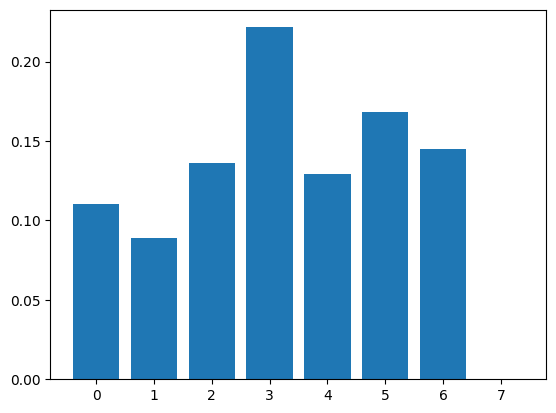

In [53]:
# Showing which features are more important in predicting:

# Changed the asset name from 'NAS:APPL' to 'NAS:AAPL'
importance = models["NAS:GOOGL"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [54]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="is_liquid"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1254, asset: 20)> Size: 201kB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01955809,  0.48115522, -0.45368716, ..., -0.04380372,
        -0.01516287, -0.39176927],
       [ 0.06103565,  0.36496811,  0.23690866, ..., -0.13047195,
        -0.33546754,  0.32737331],
       [-0.36654112, -0.52721995, -0.73987956, ..., -0.11240217,
        -0.06414652, -0.26257545]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:ADBE' 'NAS:AVGO' ... 'NYS:PFE' 'NYS:WMT'
  * time     (time) datetime64[ns] 10kB 2020-01-24 2020-01-27 ... 2025-01-17
    field    <U9 36B 'is_liquid'


In [55]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

39.698499996276574

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [56]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-13,3532.791658,0.010266,0.104856,0.000000,-0.028259,39.652120,4.157772,0.248433,20.0,1.018246,1.862106
2025-01-14,3576.634058,0.012410,0.104847,0.000000,-0.028259,39.712935,4.163775,0.860036,20.0,1.018190,1.861626
2025-01-15,3607.452711,0.008617,0.104809,0.000000,-0.028259,39.747454,4.165886,-0.065155,20.0,1.018292,1.861919
2025-01-16,3631.680931,0.006716,0.104767,0.000000,-0.028259,39.764815,4.166043,0.473328,20.0,1.018503,1.861616
2025-01-17,3631.203031,-0.000132,0.104768,-0.000132,-0.028259,39.698500,4.159147,-0.993973,20.0,1.018563,1.861525


time,2025-01-17
field,
sharpe_ratio,39.6985


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [57]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.27669380941912386

In [58]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.2767228161316072

In [59]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.8223453498881399

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [60]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [61]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [62]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s


| |#                                             | 165906 Elapsed Time: 0:00:00


fetched chunk 1/1 4s
Data loaded 4s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| |#                                               | 9060 Elapsed Time: 0:00:00
| |   #                                         | 2173150 Elapsed Time: 0:00:00


fetched chunk 1/1 4s
Data loaded 5s
---
Run all iterations...
Load data...


| |#                                               | 9060 Elapsed Time: 0:00:00
| |      #                                      | 2763233 Elapsed Time: 0:00:00


fetched chunk 1/8 2s


| |       #                                     | 2777666 Elapsed Time: 0:00:00


fetched chunk 2/8 4s


| |     #                                       | 2587302 Elapsed Time: 0:00:00


fetched chunk 3/8 6s


| |      #                                      | 3060944 Elapsed Time: 0:00:00


fetched chunk 4/8 8s


| |       #                                     | 3178333 Elapsed Time: 0:00:00


fetched chunk 5/8 10s


| |        #                                    | 3385916 Elapsed Time: 0:00:00


fetched chunk 6/8 12s


| |       #                                     | 3552388 Elapsed Time: 0:00:00


fetched chunk 7/8 14s


| |      #                                      | 3176782 Elapsed Time: 0:00:00


fetched chunk 8/8 16s
Data loaded 17s


| |#                                               | 9060 Elapsed Time: 0:00:00
| |       #                                     | 2798502 Elapsed Time: 0:00:00


fetched chunk 1/7 2s


| |     #                                       | 2926423 Elapsed Time: 0:00:00


fetched chunk 2/7 4s


| |      #                                      | 2876678 Elapsed Time: 0:00:00


fetched chunk 3/7 6s


| |        #                                    | 3056947 Elapsed Time: 0:00:00


fetched chunk 4/7 8s


| |      #                                      | 3347689 Elapsed Time: 0:00:00


fetched chunk 5/7 10s


| |       #                                     | 3493939 Elapsed Time: 0:00:00


fetched chunk 6/7 13s


| |      #                                      | 3203005 Elapsed Time: 0:00:00


fetched chunk 7/7 15s
Data loaded 15s
Backtest...


| |#                                               | 9060 Elapsed Time: 0:00:00
| |      #                                      | 2812301 Elapsed Time: 0:00:00


fetched chunk 1/7 2s


| |     #                                       | 2945777 Elapsed Time: 0:00:00


fetched chunk 2/7 4s


| |     #                                       | 2892251 Elapsed Time: 0:00:00


fetched chunk 3/7 6s


| |      #                                      | 3081609 Elapsed Time: 0:00:00


fetched chunk 4/7 8s


| |     #                                       | 3375855 Elapsed Time: 0:00:00


fetched chunk 5/7 9s


| |      #                                      | 3523925 Elapsed Time: 0:00:00


fetched chunk 6/7 11s


| |       #                                     | 3230393 Elapsed Time: 0:00:00


fetched chunk 7/7 13s
Data loaded 14s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-17
Sharpe Ratio = -1.8376380029691917


ERROR! The Sharpe Ratio is too low. -1.8376380029691917 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5044 of 5044) |####################| Elapsed Time: 0:10:29 Time:  0:10:29


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!